In [10]:
!pip -q install scikit-learn imbalanced-learn xgboost lightgbm catboost shap ydata-profiling seaborn

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve,
    precision_recall_curve, confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTENC

import shap
np.random.seed(42)



In [15]:
# -----------------------------------
# 0) OUTPUT FOLDER FOR SHAP PLOTS + OTHER PLOTS
# -----------------------------------
OUT_DIR = "shap_outputs2"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------------
# 1) LOAD DATA + MISSING VALUE SUMMARY
# -----------------------------------
file_path = r"C:\Users\plabo\OneDrive\Desktop\CSE445 Section 4\project\data\STEPS_NCD_Data_Dryad.csv"

# Tell pandas about possible missing-value codes
na_values = ["", " ", "NA", "N/A", "?", ".", "99", "999"]

try:
    df = pd.read_csv(file_path, na_values=na_values)
except Exception:
    print("Failed to read as CSV, trying Excel...")
    df = pd.read_excel(file_path, na_values=na_values)

print("Initial shape:", df.shape)

# --- Missing Value Summary Table ---
missing_table = (
    df.isnull().sum()
      .to_frame("Missing_Count")
      .assign(Missing_Percent=lambda x: (x["Missing_Count"] / len(df)) * 100)
      .query("Missing_Count > 0")
      .sort_values("Missing_Count", ascending=False)
)

print("\nMissing Values Summary (before cleaning):")
print(missing_table if not missing_table.empty else "✅ No missing values detected")



Initial shape: (8042, 34)

Missing Values Summary (before cleaning):
             Missing_Count  Missing_Percent
h3                    6937        86.259637
h2b                   6633        82.479483
hx1                   6633        82.479483
t2                    6154        76.523253
h7a                   5661        70.392937
t13                   5453        67.806516
t15                   2591        32.218354
h2a                   2096        26.063168
t8                    1888        23.476747
salt_intake           1287        16.003482
b5                    1123        13.964188
BMI                    173         2.151206
m14                    165         2.051728
SBP                     31         0.385476
DBP                     31         0.385476
c8                       3         0.037304


In [3]:
# -----------------------------------
# 2) BASIC CLEANING / TRANSFORMS
# -----------------------------------
def convert_custom(val):
    """
    Convert strings like '100-120', '>=140', '<90' into numeric points.
    If a pure number string, cast to float; else return NaN.
    """
    if isinstance(val, str):
        val = val.strip()
        try:
            if '-' in val and not val.startswith(('>', '<', '>=', '<=')):
                low, high = val.split('-')
                return (float(low) + float(high)) / 2
            elif val.startswith('>='):
                return float(val[2:])
            elif val.startswith('<='):
                return float(val[2:])
            elif val.startswith('>'):
                return float(val[1:]) + 1
            elif val.startswith('<'):
                return float(val[1:]) - 1
            else:
                return float(val)
        except:
            return np.nan
    return val

numeric_columns = [
    'b5', 'b8', 'm14', 'salt_intake', 'BMI', 'SBP', 'DBP',
    'PA_in day', 'Fruits_in day', 'Veg_in day', 'Fruits_Veg', 'agerange'
]
for col in numeric_columns:
    if col in df.columns:
        df[col] = df[col].apply(convert_custom)

# Label-encode key categoricals used early
basic_categoricals = ['psutype', 'gender', 'Wealth index']
for col in basic_categoricals:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Median fill for numerics 
for col in ['b5', 'salt_intake', 'BMI', 'SBP', 'DBP', 'm14']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Drop columns judged irrelevant in workflow
cols_to_remove = ['t13', 't2', 't9','h13a', 'h13b', 'h14', 'h2b', 'h7b',
                  'h8', 'h9', 'h3', 'hx5','hx1','h7a','c1','b1']
df.drop(columns=[c for c in cols_to_remove if c in df.columns], inplace=True, errors='ignore')

# Mode fill for some categoricals later used
mode_fill_cols = ['h2a', 't8', 't15','c8']
for col in mode_fill_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

df.drop_duplicates(inplace=True)
print("After cleaning shape:", df.shape)





After cleaning shape: (7896, 27)


In [4]:
# -----------------------------------
# PLOT: Correlation heatmap & Histograms/Value Counts (once after cleaning)
# -----------------------------------
try:
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,              # numbers inside cells
        fmt=".2f",               # 2 decimals
        cmap="coolwarm",
        center=0,
        square=True,             # square cells
        linewidths=0.5,          # grid lines
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlation Heatmap (numeric features)", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    fname = os.path.join(OUT_DIR, "correlation_heatmap_styled.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()
    print(f"Saved correlation heatmap to: {fname}")
except Exception as e:
    print("Failed to create styled correlation heatmap:", e)

try:
    # Histograms / Value counts grid
    num_cols = numeric_df.columns.tolist()
    ncols = 4
    nrows = int(np.ceil(len(num_cols) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        ax = axes[i]
        if numeric_df[col].nunique() <= 10:  # categorical-like
            numeric_df[col].value_counts().sort_index().plot(kind="bar", ax=ax)
            ax.set_title(f"Value Counts: {col}")
        else:  # continuous
            ax.hist(numeric_df[col].dropna(), bins=30)
            ax.set_title(f"Histogram: {col}")
        ax.tick_params(axis="x", rotation=45)

    # Turn off empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Numeric Feature Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fname = os.path.join(OUT_DIR, "numeric_feature_distributions.png")
    plt.savefig(fname, dpi=300)
    plt.close()
    print(f"Saved numeric feature distributions to: {fname}")
except Exception as e:
    print("Failed to create histograms/value counts:", e)



Saved correlation heatmap to: shap_outputs2\correlation_heatmap_styled.png
Saved numeric feature distributions to: shap_outputs2\numeric_feature_distributions.png


In [5]:
 from ydata_profiling import ProfileReport

# Create the report
profile = ProfileReport(df, title="Profiling Report", explorative=True)

# Display it inside the notebook
profile.to_notebook_iframe()
profile.to_file("profiling_report.html") 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 68.40it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# 3) TARGETS & FEATURES
# -----------------------------------
# Survey targets to {0,1}
for col in ['h8_or_h9', 'h2a']:
    if col in df.columns:
        df[col] = df[col].replace({2: 0, '2.0': 0, '1.0': 1})

# Encode broader set of categoricals as codes for modeling
categorical_column_names = [
    'psutype', 'Current drinker', 't1', 't12', 't15', 't8',
    'c8', 'h1', 'gender', 'c7', 'c5', 'Wealth index',
    '<5 servings_fruits_veg', 'h2a', 'h8_or_h9'
]
for col in categorical_column_names:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

# Feature sets
diabetes_features = [
    'agerange', 'BMI', 'm14', 'PA_in day', 'b8',
    'Fruits_in day', 'Veg_in day', 'Fruits_Veg', 'salt_intake',
    'Wealth index', 'Current drinker', 't1', 't12', 'psutype', 'c8','h8_or_h9','h2a'
]
hypertension_features = [
    'agerange', 'BMI', 'm14', 'salt_intake', 'b8', 'b5', 'Wealth index',
    'PA_in day', 'Fruits_in day', 'Veg_in day', 'Fruits_Veg', 'Current drinker',
    't1', 't12', 't15', 't8', 'psutype', 'c8', 'h1','h8_or_h9','h2a'
]
obesity_features = [
    'agerange', 'psutype', 'PA_in day', 'b5', 'Wealth index',
    'Fruits_in day', 'Veg_in day', 'Fruits_Veg', 'salt_intake',
    'Current drinker', 't1', 't12', 't15', 't8', 'c8','h8_or_h9','h2a'
]
hyperg_features = [
    'agerange', 'psutype', 'PA_in day', 'Wealth index',
    'Fruits_in day', 'Veg_in day', 'Fruits_Veg', 'salt_intake',
    'Current drinker', 't1', 't12', 't15', 't8', 'c8','h8_or_h9','h2a'
]

# Binary clinical targets
df['diabetes_clinical']  = (df['b5']  >= 126).astype(int)
df['hypertension_bp']    = ((df['SBP'] >= 140) | (df['DBP'] >= 90)).astype(int)
df['overweight_obesity'] = (df['BMI'] >= 25).astype(int)
df['hyperglycemia']      = (df['b5'] >= 110).astype(int)

# Which tasks to run
tasks = {
    'diabetes': {
        'targets': {'diabetes_clinical': df['diabetes_clinical']},
        'features': diabetes_features,
        'use_smote': True  # heavy imbalance -> SMOTENC
    },
    'hypertension': {
        'targets': {'hypertension_clinical': df['hypertension_bp']},
        'features': hypertension_features,
        'use_smote': False # moderate imbalance -> rely on class_weight
    },
    'overweight_obesity': {
        'targets': {'overweight_obesity': df['overweight_obesity']},
        'features': obesity_features,
        'use_smote': False # ~70:30 acceptable
    },
    'hyperglycemia': {
        'targets': {'hyperglycemia': df['hyperglycemia']},
        'features': hyperg_features,
        'use_smote': True  # heavy-ish imbalance
    }
}

def get_categorical_indices(feature_list, categorical_columns):
    """Indices for SMOTENC categorical_features argument (by column position)."""
    return [i for i, col in enumerate(feature_list) if col in categorical_columns]


In [7]:
# -----------------------------------
# 4) MODEL ZOO + PARAM GRIDS (tuned with CV)
# -----------------------------------
def build_models_and_grids(pos_weight=1.0, moderate_imbalance=False):
    """
    pos_weight: suggested weight (for XGB/LGBM) computed from train set.
    moderate_imbalance: if True, use class_weight='balanced' in linear/SVM grids.
    """
    # Base models
    lr  = LogisticRegression(max_iter=2000, random_state=42)
    rf  = RandomForestClassifier(random_state=42, n_jobs=-1)
    xgb = XGBClassifier(
        random_state=42, eval_metric='logloss', n_jobs=-1,
        scale_pos_weight=pos_weight
    )
    lgb = LGBMClassifier(
        random_state=42, n_jobs=-1, n_estimators=500,
        class_weight='balanced' if moderate_imbalance else None
    )
    ctb = CatBoostClassifier(
        random_state=42, verbose=0, eval_metric='AUC',
        class_weights=None
    )
    svm = SVC(probability=True, random_state=42)

    # Param grids (compact but effective)
    cw = ['balanced'] if moderate_imbalance else [None, 'balanced']
    models = {
        'Logistic Regression': (lr, {
            'est__C': [0.01, 0.1, 1, 10],
            'est__penalty': ['l2'],
            'est__class_weight': cw,
            'est__solver': ['liblinear', 'lbfgs']
        }),
        'Random Forest': (rf, {
            'est__n_estimators': [300, 600],
            'est__max_depth': [None, 8, 16, 24],
            'est__min_samples_split': [2, 5, 10],
            'est__min_samples_leaf': [1, 2, 4],
            'est__class_weight': [None, 'balanced']
        }),
        'XGBoost': (xgb, {
            'est__n_estimators': [300, 600],
            'est__learning_rate': [0.01, 0.05, 0.1],
            'est__max_depth': [3, 5, 7],
            'est__subsample': [0.7, 1.0],
            'est__colsample_bytree': [0.7, 1.0],
            'est__reg_lambda': [1, 5, 10]
        }),
        'LightGBM': (lgb, {
            'est__num_leaves': [15, 31, 63],
            'est__learning_rate': [0.01, 0.05, 0.1],
            'est__max_depth': [-1, 8, 16],
            'est__min_child_samples': [20, 50, 100],
            'est__subsample': [0.7, 1.0],
            'est__colsample_bytree': [0.7, 1.0],
            'est__reg_lambda': [0, 1, 5]
        }),
        'CatBoost': (ctb, {
            'est__depth': [4, 6, 8],
            'est__learning_rate': [0.01, 0.05, 0.1],
            'est__l2_leaf_reg': [1, 3, 5],
            'est__iterations': [300, 600]
        }),
        'SVM': (svm, {
            'est__C': [0.1, 1, 10],
            'est__kernel': ['rbf', 'linear'],
            'est__gamma': ['scale', 'auto'],
            'est__class_weight': cw
        })
    }
    return models

In [8]:
# -----------------------------------
# 5) TUNING + EVALUATION UTILITIES
# -----------------------------------
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(y_true, y_prob, y_pred):
    """Return dict of metrics on test set."""
    return {
        'ROC_AUC': roc_auc_score(y_true, y_prob) if len(np.unique(y_true))==2 else np.nan,
        'PR_AUC': average_precision_score(y_true, y_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    }

def tune_one_model(X_train, y_train, X_test, y_test, model_name, base_estimator, param_grid,
                   use_scaler=False, use_smote=False, cat_indices=None):
    """
    Pipeline: [SMOTENC?] -> [Scaler?] -> Estimator
    GridSearchCV(ROC-AUC). Returns best estimator (pipeline), best_params, test metrics.
    """
    steps = []
    if use_smote and cat_indices is not None:
        steps.append(('smote', SMOTENC(categorical_features=cat_indices, random_state=42, sampling_strategy='auto')))
    if use_scaler:
        steps.append(('scaler', StandardScaler()))
    steps.append(('est', base_estimator))
    pipe = ImbPipeline(steps)

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv5,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    y_prob = best.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = evaluate(y_test, y_prob, y_pred)
    return best, gs.best_params_, metrics

# -----------------------------------
# 6) SHAP HELPERS
# -----------------------------------
def is_tree_model(est):
    
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    from sklearn.ensemble import RandomForestClassifier
    return isinstance(est, (XGBClassifier, LGBMClassifier, CatBoostClassifier, RandomForestClassifier))

def build_inference_transformer(best_pipe):
    steps = []
    if 'scaler' in best_pipe.named_steps:
        steps.append(('scaler', best_pipe.named_steps['scaler']))
    steps.append(('est', best_pipe.named_steps['est']))
    return SkPipeline(steps)

def run_and_save_shap(disease, target, best_pipe, X_train, X_test, feature_names):
    est = best_pipe.named_steps['est']
    needs_scaler = 'scaler' in best_pipe.named_steps

    # Prepare data for explainer
    # Background sample for KernelExplainer
    bg_size = min(200, len(X_train))
    X_bg = X_train.sample(bg_size, random_state=42)

    # Build inference transform (scaler only, no SMOTE)
    inf_pipe = build_inference_transformer(best_pipe)

    # Choose explainer
    if is_tree_model(est):
        explainer = shap.TreeExplainer(est)
        shap_values = explainer.shap_values(X_test)
        
        if isinstance(shap_values, list):
            # pick positive class (1)
            shap_vals_pos = shap_values[1]
        else:
            shap_vals_pos = shap_values
        base_values = getattr(explainer, 'expected_value', None)
        if isinstance(base_values, list) or isinstance(base_values, np.ndarray):
            base_value = base_values[1] if np.ndim(base_values) > 0 else base_values
        else:
            base_value = base_values

        # --- Global: beeswarm ---
        plt.figure()
        shap.summary_plot(shap_vals_pos, features=X_test, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_beeswarm.png"), dpi=300)
        plt.close()

        # --- Global: bar ---
        plt.figure()
        shap.summary_plot(shap_vals_pos, features=X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_bar.png"), dpi=300)
        plt.close()

        # --- Local: pick top-risk case by predicted probability ---
        y_prob = est.predict_proba(X_test)[:, 1]
        top_idx = np.argsort(-y_prob)[0]
        shap_ex = shap.Explanation(values=shap_vals_pos[top_idx],
                                   base_values=base_value,
                                   data=X_test.iloc[top_idx],
                                   feature_names=feature_names)
        plt.figure()
        shap.plots.waterfall(shap_ex, max_display=15, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_waterfall.png"), dpi=300)
        plt.close()

    else:
        # Linear / SVM: use LinearExplainer for LR, KernelExplainer for others
        if isinstance(est, LogisticRegression):
            # Transform inputs via scaler if present
            X_bg_t = inf_pipe.named_steps['scaler'].transform(X_bg) if 'scaler' in inf_pipe.named_steps else X_bg.values
            X_test_t = inf_pipe.named_steps['scaler'].transform(X_test) if 'scaler' in inf_pipe.named_steps else X_test.values

            explainer = shap.LinearExplainer(est, X_bg_t, feature_names=feature_names)
            shap_vals = explainer.shap_values(X_test_t)

            # Global plots
            plt.figure()
            shap.summary_plot(shap_vals, X_test, feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_beeswarm.png"), dpi=300)
            plt.close()

            plt.figure()
            shap.summary_plot(shap_vals, X_test, feature_names=feature_names, plot_type="bar", show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_bar.png"), dpi=300)
            plt.close()

            # Local: top-risk case
            y_prob = inf_pipe.predict_proba(X_test)[:, 1]
            top_idx = np.argsort(-y_prob)[0]
            shap_ex = shap.Explanation(values=shap_vals[top_idx],
                                       base_values=explainer.expected_value,
                                       data=X_test.iloc[top_idx],
                                       feature_names=feature_names)
            plt.figure()
            shap.plots.waterfall(shap_ex, max_display=15, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_waterfall.png"), dpi=300)
            plt.close()
        else:
            # Generic fallback (e.g., SVM): KernelExplainer on predict_proba
            f = lambda X: inf_pipe.predict_proba(pd.DataFrame(X, columns=feature_names))[:, 1]
            X_bg_k = shap.sample(X_bg, min(100, len(X_bg))).values
            X_test_k = X_test.values[:200]  # subsample for speed
            explainer = shap.KernelExplainer(f, X_bg_k)
            shap_vals = explainer.shap_values(X_test_k, nsamples=200)

            # Global plots
            plt.figure()
            shap.summary_plot(shap_vals, X_test.iloc[:len(X_test_k)], feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_beeswarm.png"), dpi=300)
            plt.close()

            plt.figure()
            shap.summary_plot(shap_vals, X_test.iloc[:len(X_test_k)], feature_names=feature_names, plot_type="bar", show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_bar.png"), dpi=300)
            plt.close()

            # Local: top-risk case within the subset
            y_prob = inf_pipe.predict_proba(X_test.iloc[:len(X_test_k)])[:, 1]
            top_idx = np.argsort(-y_prob)[0]
            shap_ex = shap.Explanation(values=np.array(shap_vals)[top_idx],
                                       base_values=explainer.expected_value,
                                       data=X_test.iloc[top_idx],
                                       feature_names=feature_names)
            plt.figure()
            shap.plots.waterfall(shap_ex, max_display=15, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{disease}__{target}__SHAP_waterfall.png"), dpi=300)
            plt.close()


In [9]:
# -----------------------------------
# 7) MAIN LOOP: per disease/target
# -----------------------------------
all_results = {}
best_models_for_shap = {}  # store best single model per (disease, target)

for disease, cfg in tasks.items():
    feats = cfg['features']
    use_smote_here = cfg['use_smote']
    cat_indices = get_categorical_indices(feats, categorical_column_names)

    X_full = df[feats].copy()
    for tgt_name, y_full in cfg['targets'].items():
        print("\n" + "="*90)
        print(f"{disease.upper()}  —  Target: {tgt_name}")
        print("="*90)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
        )

        # Compute pos_weight for boosters: (neg/pos) in TRAIN ONLY
        pos_count = np.sum(y_train==1)
        neg_count = np.sum(y_train==0)
        pos_weight = float(neg_count) / float(max(pos_count, 1))

        moderate_imbalance = not use_smote_here  # for LR/SVM class_weight emphasis

        models = build_models_and_grids(pos_weight=pos_weight,
                                        moderate_imbalance=moderate_imbalance)

        scaled_models = ['Logistic Regression', 'SVM']  # tree/boosters don't need scaling

        disease_results = []
        tuned_estimators_for_stacking = []
        model_records_for_selection = []

        for model_name, (estimator, grid) in models.items():
            print(f"\nTuning {model_name} ...")
            use_scaler = model_name in scaled_models

            best_est, best_params, test_metrics = tune_one_model(
                X_train, y_train, X_test, y_test,
                model_name=model_name,
                base_estimator=estimator,
                param_grid=grid,
                use_scaler=use_scaler,
                use_smote=use_smote_here,
                cat_indices=cat_indices
            )

            tuned_estimators_for_stacking.append((model_name.replace(" ", "_").lower(), best_est.named_steps['est']))
            print("  Best params:", best_params)
            print("  Test metrics:",
                  {k: (round(v, 4) if isinstance(v, float) else v) for k, v in test_metrics.items()})

            disease_results.append({
                'model': model_name,
                'best_params': best_params,
                **test_metrics
            })

            model_records_for_selection.append((model_name, best_est, test_metrics['ROC_AUC']))

        # ---------- Stacking Ensemble ----------
        print("\nFitting Stacking Ensemble ...")
        base_for_stack = tuned_estimators_for_stacking
        meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

        stack_pipe = ImbPipeline(steps=[
            ('smote', SMOTENC(categorical_features=cat_indices, random_state=42, sampling_strategy='auto')) if use_smote_here else ('smote', 'passthrough'),
            ('stack', StackingClassifier(
                estimators=base_for_stack,
                final_estimator=meta_lr,
                stack_method='predict_proba',
                passthrough=False, n_jobs=-1, cv=cv5
            ))
        ])

        stack_pipe.fit(X_train, y_train)
        y_prob = stack_pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        stack_metrics = evaluate(y_test, y_prob, y_pred)

        print("  Stacking Test metrics:",
              {k: (round(v, 4) if isinstance(v, float) else v) for k, v in stack_metrics.items()})

        disease_results.append({
            'model': 'Stacking Ensemble',
            'best_params': '— (meta LR + tuned bases)',
            **stack_metrics
        })

        # Store summary df
        res_df = pd.DataFrame(disease_results)
        all_results[(disease, tgt_name)] = res_df

        # Pick best single model (exclude stacking) by ROC_AUC for SHAP
        best_single_name, best_single_est, _ = sorted(
            [(n, est, auc) for (n, est, auc) in model_records_for_selection],
            key=lambda x: x[2], reverse=True
        )[0]
        best_models_for_shap[(disease, tgt_name)] = (best_single_name, best_single_est)

        # --- Run SHAP on the best single model ---
        print(f"\nRunning SHAP for best single model: {best_single_name}")
        run_and_save_shap(
            disease=disease,
            target=tgt_name,
            best_pipe=best_single_est,
            X_train=X_train,
            X_test=X_test,
            feature_names=feats
        )



DIABETES  —  Target: diabetes_clinical

Tuning Logistic Regression ...
  Best params: {'est__C': 0.01, 'est__class_weight': None, 'est__penalty': 'l2', 'est__solver': 'lbfgs'}
  Test metrics: {'ROC_AUC': np.float64(0.7713), 'PR_AUC': np.float64(0.3872), 'Accuracy': 0.7557, 'Precision': 0.1783, 'Recall': 0.6218, 'F1': 0.2772}

Tuning Random Forest ...
  Best params: {'est__class_weight': None, 'est__max_depth': 8, 'est__min_samples_leaf': 4, 'est__min_samples_split': 10, 'est__n_estimators': 600}
  Test metrics: {'ROC_AUC': np.float64(0.7742), 'PR_AUC': np.float64(0.3051), 'Accuracy': 0.8892, 'Precision': 0.3228, 'Recall': 0.4286, 'F1': 0.3682}

Tuning XGBoost ...
  Best params: {'est__colsample_bytree': 0.7, 'est__learning_rate': 0.01, 'est__max_depth': 3, 'est__n_estimators': 300, 'est__reg_lambda': 10, 'est__subsample': 1.0}
  Test metrics: {'ROC_AUC': np.float64(0.7766), 'PR_AUC': np.float64(0.336), 'Accuracy': 0.131, 'Precision': 0.0781, 'Recall': 0.9748, 'F1': 0.1445}

Tuning Lig

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
# -----------------------------------
# 8) PRINT SUMMARY TABLES
# -----------------------------------
for (disease, tgt), dfres in all_results.items():
    print("\n" + "#"*90)
    print(f"SUMMARY — {disease.upper()}  |  target = {tgt}")
    print("#"*90)
    display_cols = ['model', 'ROC_AUC', 'PR_AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'best_params']
    print(dfres[display_cols].sort_values(by='ROC_AUC', ascending=False).to_string(index=False))

print(f"\nSHAP figures saved to: {os.path.abspath(OUT_DIR)}")
print("Files include: *_SHAP_beeswarm.png, *_SHAP_bar.png, *_SHAP_waterfall.png per disease/target.")


##########################################################################################
SUMMARY — DIABETES  |  target = diabetes_clinical
##########################################################################################
              model  ROC_AUC   PR_AUC  Accuracy  Precision   Recall       F1                                                                                                                                                                        best_params
           CatBoost 0.784673 0.352171  0.912025   0.415254 0.411765 0.413502                                                                                       {'est__depth': 4, 'est__iterations': 300, 'est__l2_leaf_reg': 3, 'est__learning_rate': 0.01}
            XGBoost 0.776598 0.336037  0.131013   0.078062 0.974790 0.144548                            {'est__colsample_bytree': 0.7, 'est__learning_rate': 0.01, 'est__max_depth': 3, 'est__n_estimators': 300, 'est__reg_lambda': 10, 'est__subsample': 1.0}

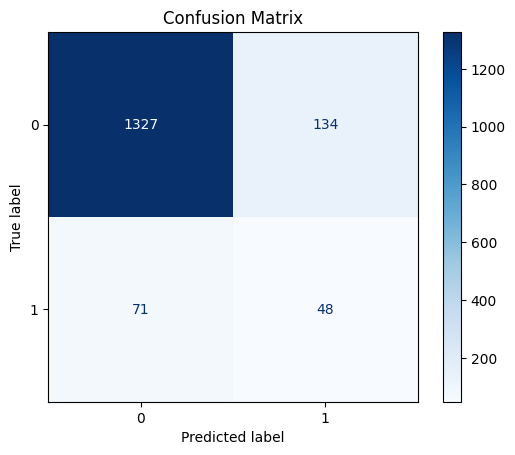

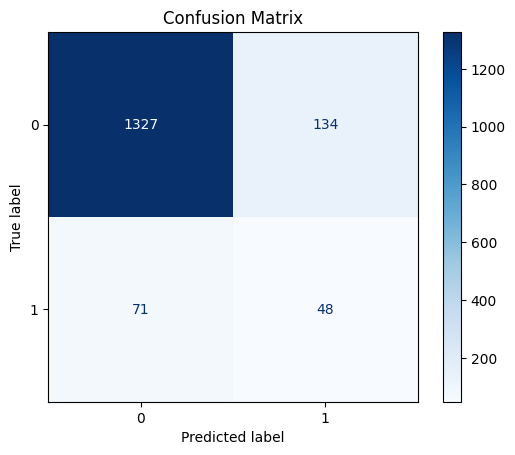

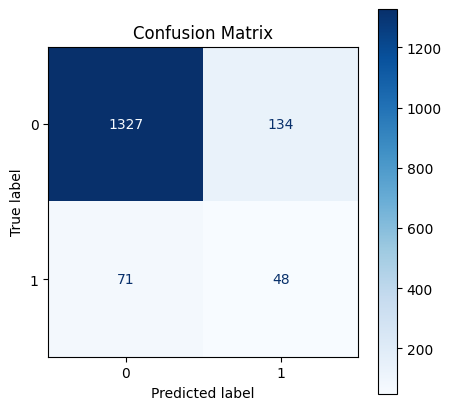

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)

plt.title("Confusion Matrix")
plt.show()


<Figure size 600x400 with 0 Axes>

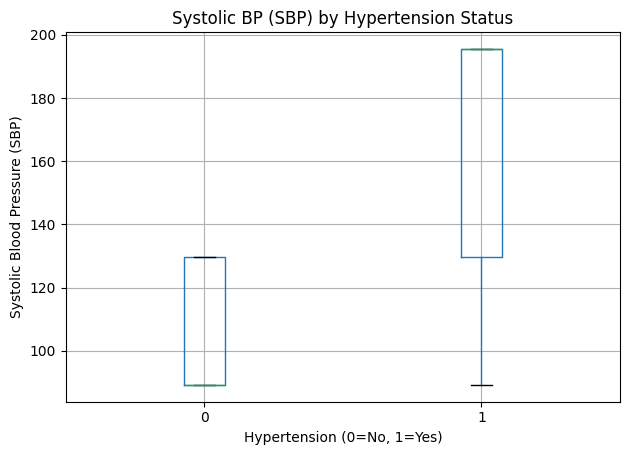

<Figure size 600x400 with 0 Axes>

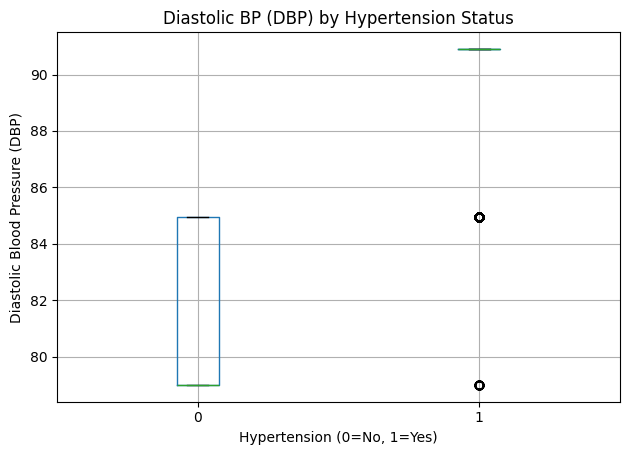

<Figure size 600x400 with 0 Axes>

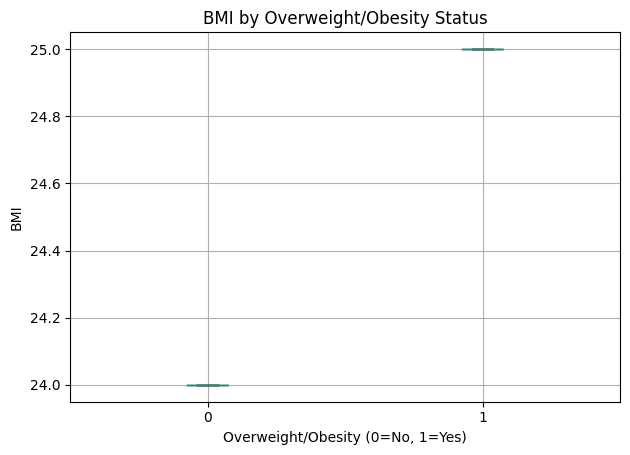

<Figure size 600x400 with 0 Axes>

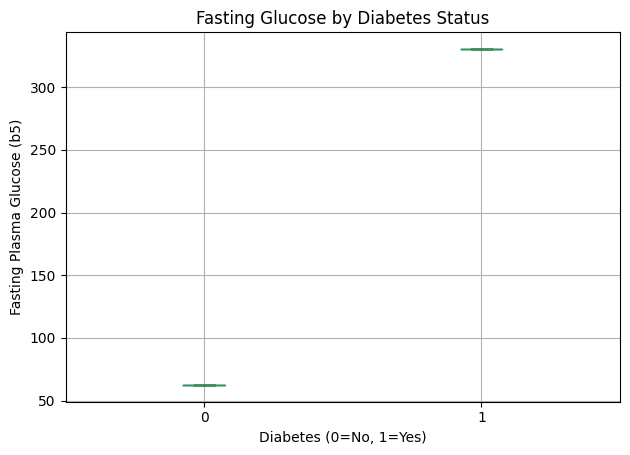

<Figure size 600x400 with 0 Axes>

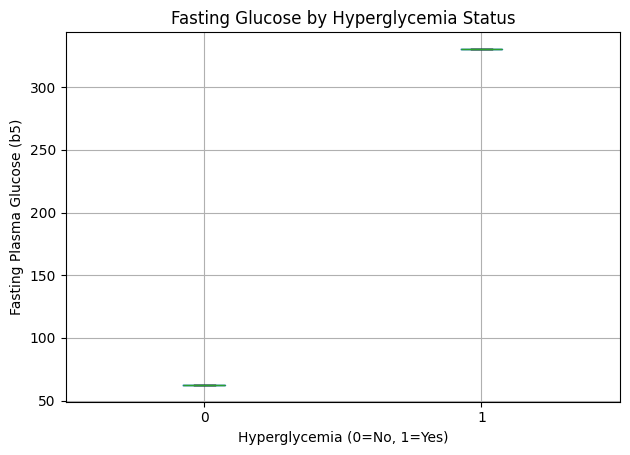

In [17]:
import matplotlib.pyplot as plt

# SBP by Hypertension Status
plt.figure(figsize=(6,4))
df.boxplot(column='SBP', by='hypertension_bp')
plt.title('Systolic BP (SBP) by Hypertension Status')
plt.suptitle('')
plt.xlabel('Hypertension (0=No, 1=Yes)')
plt.ylabel('Systolic Blood Pressure (SBP)')
plt.tight_layout()
plt.show()

# DBP by Hypertension Status
plt.figure(figsize=(6,4))
df.boxplot(column='DBP', by='hypertension_bp')
plt.title('Diastolic BP (DBP) by Hypertension Status')
plt.suptitle('')
plt.xlabel('Hypertension (0=No, 1=Yes)')
plt.ylabel('Diastolic Blood Pressure (DBP)')
plt.tight_layout()
plt.show()
# BMI by overweight/obesity status
plt.figure(figsize=(6,4))
df.boxplot(column='BMI', by='overweight_obesity')
plt.title('BMI by Overweight/Obesity Status')
plt.suptitle('')
plt.xlabel('Overweight/Obesity (0=No, 1=Yes)')
plt.ylabel('BMI')
plt.tight_layout()
plt.show()
# Fasting Plasma Glucose by diabetes status
plt.figure(figsize=(6,4))
df.boxplot(column='b5', by='diabetes_clinical')
plt.title('Fasting Glucose by Diabetes Status')
plt.suptitle('')
plt.xlabel('Diabetes (0=No, 1=Yes)')
plt.ylabel('Fasting Plasma Glucose (b5)')
plt.tight_layout()
plt.show()

#  Fasting Plasma Glucose by hyperglycemia status
plt.figure(figsize=(6,4))
df.boxplot(column='b5', by='hyperglycemia')
plt.title('Fasting Glucose by Hyperglycemia Status')
plt.suptitle('')
plt.xlabel('Hyperglycemia (0=No, 1=Yes)')
plt.ylabel('Fasting Plasma Glucose (b5)')
plt.tight_layout()
plt.show()